만약 데이터가 선형적이지 않다면 우리는 그 데이터를 분류를 이용하여 패턴을 예측할 수 있습니다.

트리기반모델은 회귀와 분류 문제에서 모두 쓰일 수 있는 장점이 있습니다.

하지만 오늘은 분류 문제에 대해 정리해보겠습니다.

In [66]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
import graphviz
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer

In [3]:
target = "vacc_h1n1_f"

train = pd.merge(
    pd.read_csv(
        "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv"
    ),
    pd.read_csv(
        "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv"
    )[target],
    left_index=True,
    right_index=True,
)

In [7]:
train[target].value_counts(normalize = True) # normalize = True -> 비율로 보이게

0    0.760948
1    0.239052
Name: vacc_h1n1_f, dtype: float64

타겟을 보고 binary한지 아닌지를 파악하고  분류를 이용할지말지 결정합니다. 

만약 비율 자체가 불균형하다면 stratify로 각 데이터들을 분할할 때 같은 비율로 분할한 후 

모델을 학습할 때 상대적으로 적은 비중에 가중치를 두어(Treshold를 올리고 내리고) 모델이 데이터를 학습하기 원활하게 도와줘야 하겠습니다.

In [9]:
train, val = train_test_split(train,
                              train_size = .8, 
                              test_size = .2, 
                              stratify = train[target], 
                              random_state = 42)

### 카디널리티가 높은 특성만 제거해주겠습니다.

In [46]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다.""" # 함수의 역할을 알려주는 doc 기능
    selected_cols = df.select_dtypes(include=["number", "object"])
    labels = selected_cols.nunique()  
    selected_features = labels[labels <= 30].index.tolist() 
    df = df[selected_features]
    return df
train = engineer(train)
val = engineer(val)

In [47]:
features = train.drop(target, axis = 1).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

### sklearn 이용 시 결측치 처리가 자동으로 안돼서 imputer로 처리하거나 적절히 대치해줘야 합니다.

In [54]:
dtpipe = Pipeline(
                    [('ordinalencoder', OrdinalEncoder()),
                     ('simpleimputer', SimpleImputer()),
                     ('decisiontreeclassifier', DecisionTreeClassifier(random_state = 42, criterion = "gini",
                                                                       class_weight = 'balanced'))],
)
dtpipe.fit(X_train, y_train)

print("훈련 정확도: ", dtpipe.score(X_train, y_train))
print("검증 정확도: ", dtpipe.score(X_val, y_val))

훈련 정확도:  0.9914745348061383
검증 정확도:  0.752112676056338


### Classification

<img src = "https://drive.google.com/uc?id=1_INZ08l3RVtfDWO9sI3ZdmMTrQ9JpbpO" width = 500 height = 300>


결정트리는 비용함수(Impurity)를 최소화 하는 특성의 값을 Yes / No 라는 binary한 기준으로 분류해나가는 과정입니다.

이를 데이터를 기반으로 모델을 만든다고 했을 때는....

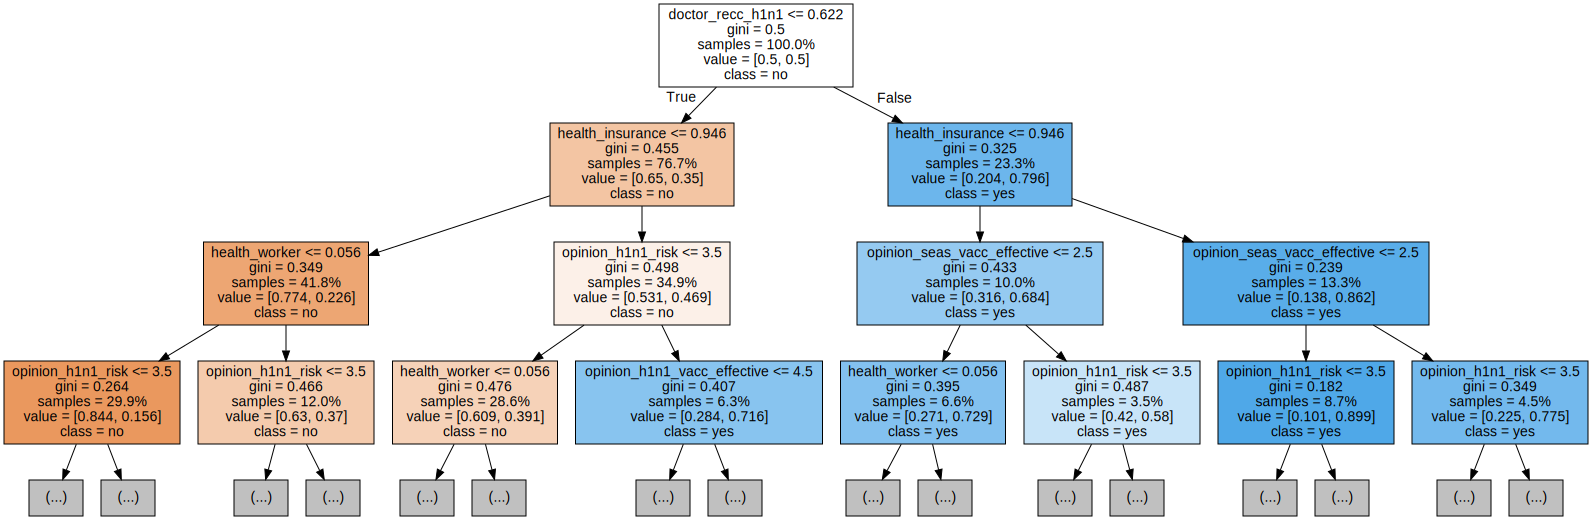

In [55]:
model_dt = dtpipe.named_steps['decisiontreeclassifier']
enc = dtpipe.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth = 3
                          , feature_names = encoded_columns
                          , class_names = ['no', 'yes']
                          , filled = True
                          , proportion = True)


display(graphviz.Source(dot_data))


이런식으로 만들어질 수 있겠습니다.

각 노드들은 특성이 나뉘는 기준이 무엇이고, 그 기준에 의해 나눠진 특성들이 존재함을 알 수 있습니다.

Root Node (최상단 노드)는 doctor_recc_h1n1 <= 0.622 라는 기준으로 트리를 분기했고,

그 다음 노드들도 어떠한 기준을 갖고 트리를 계속해서 분기해나가는 모습을 볼 수 있습니다.

각 노드들의 위치는 gini impurity 라는 비용함수를 기준으로 정해집니다.

위의 과정에서 자연스럽게 우리는 비선형적인 데이터에서는 파악하기 힘들었던 피쳐간 상호작용, 연관성을 포착할 수 있게된다는 장점이 있습니다.

예를 들어 doctor_recc_h1n1 <= 0.622 , health_insurance <= 0.946 이면 health_worker 집단이 많구나 라는 연관성을 알 수 있습니다.

이렇게 결정나무는 시각화에 큰 장점이 있습니다. 하지만

만약 데이터를 관성적으로 스케일링한다 했을 때 그 트리를 시각화 한다면, 0.622 이라는 기준값이 스케일링 돼버리니

시각화라는 장점이 사라지게 돼버립니다. 

또한 결측치의 부분도 결측치 자체가 하나의 지표가 될 수 있기 때문에

분류문제에서는 간단하게 생각할 부분이 아닙니다.(무턱대고 fill하면 안된다는 말 입니다.)

그래서 요약하자면, 트리기반모델에서는 많은 전처리가 필요없다는 편리함과 시각화에 장점이 있다고 말할 수 있겠습니다.

각 특성이 얼마나 먼저, 많이 분기에 사용되었는지로 정의된 특성 중요도를 보고 각 특성이 얼마나 크리티컬 했는지를 아는 방법도 있습니다.

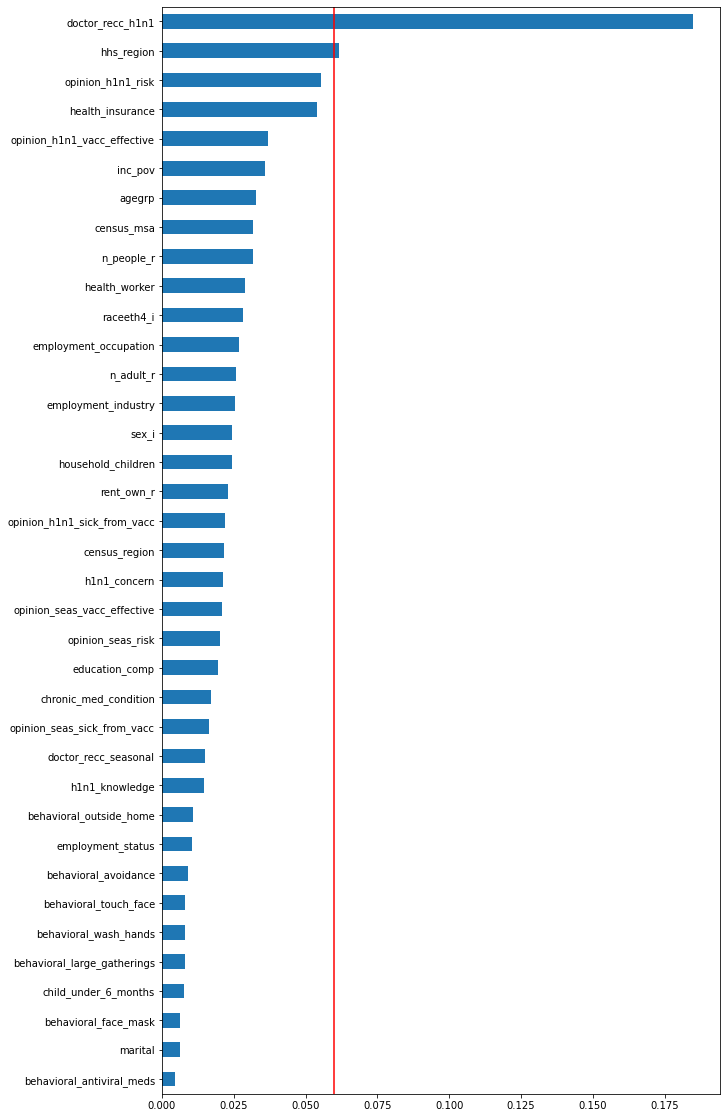

In [65]:
%matplotlib inline
importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(10,20))
importances.sort_values(ascending = True).plot.barh();
plt.axvline(x = 0.06, color = 'red');

어떤 특성의 feature_importance_ 값이 낮다고 해서 이 특성이 유용하지 않다는 뜻은 아닙니다. 

단지 트리가 그 특성을 선택하지 않았을 뿐이며, 다른 특성이 동일한 정보를 지니고 있어서일 수 있습니다.

### Randomforest 

랜덤포레스트는 각각의 DT들이 모여서 숲을 이루었다고 생각하면 쉽습니다.

각 트리에서 랜덤하게 도출된 결과값들을 취합하여 최종적인 결과를 도출합니다.

이를 Bootstrap Aggregating Bagging 이라 합니다.

따라서 RF로 만든 모델은 분산을 줄이고 편향을 늘려 과적합을 피할 수 있고, 일반화 성능을 더 좋게 만들어 줄 수 있습니다.

또한 Bootstrap 과정에서 사용되지 않은 데이터들(복원 추출이기 때문)은 따로 모아 검증에 활용할 수도 있습니다. (out of bagging oob라 칭합니다.)

In [72]:
rfpipe = Pipeline(
    [('ordinalencoder', OrdinalEncoder()),
    ('simpleimputer', SimpleImputer()),
    ('randomforestclassifier', RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1,class_weight='balanced'))],
)

rfpipe.fit(X_train, y_train)
print("훈련 정확도: ", rfpipe.score(X_train, y_train))
print("검증 정확도: ", rfpipe.score(X_val, y_val))

훈련 정확도:  0.9928830899251242
검증 정확도:  0.829058561897702


In [73]:
rfpipe.named_steps["randomforestclassifier"].oob_score_ #oob sample -> test용 으로 스코어를 낸 결과

0.8184446586107198